In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import hvplot.pandas
import plotly.express as px
import numpy as np
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import  risk_models
from pypfopt import expected_returns
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
from pypfopt import plotting

import warnings
warnings.filterwarnings("ignore")


In [2]:
#formatting floats to 2 decimals to avoid use of scientific notation
pd.options.display.float_format = '{:.2f}'.format

In [3]:
#Defining symbols in our portfolio.
tickers = ["TSLA", "BIDU", "NVDA", "AAL", "AMD", "WMT", "DIS", "DHR", "PANW","AAPL","MCL.CN","FI"] 

In [4]:
portfolio_creation_date = "2023-11-10"
portfolio_rebalance_date = "2023-11-10"

In [5]:
#Downloading 10 years of data from yahoo finance.
stock_data = yf.download(tickers, period="10y")

[*********************100%%**********************]  12 of 12 completed


In [6]:
#putting stock data into a df called prices
prices = pd.DataFrame(stock_data["Adj Close"].dropna(how="all"))
prices

,AAL,AAPL,AMD,BIDU,DHR,DIS,FI,MCL.CN,NVDA,PANW,TSLA,WMT
Date,,,,,,,,,,,,
2013-11-11,21.94,16.25,3.34,151.60,47.24,62.13,26.34,0.02,3.68,13.96,9.65,63.73
2013-11-12,22.17,16.28,3.44,150.43,46.94,61.61,26.41,0.02,3.69,13.76,9.19,63.48
2013-11-13,21.98,16.30,3.54,152.98,46.85,62.70,26.80,0.02,3.79,13.82,9.25,63.64
2013-11-14,22.31,16.54,3.52,158.99,47.29,63.65,26.80,0.02,3.81,14.07,9.17,63.78
2013-11-15,22.52,16.44,3.50,162.33,47.32,63.64,27.15,0.02,3.79,15.24,9.03,63.90
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-06,11.66,178.99,111.75,108.40,195.52,84.02,119.64,0.08,457.51,237.00,219.27,164.88
2023-11-07,11.75,181.58,113.45,108.01,198.25,84.59,119.21,0.08,459.55,242.08,222.18,165.65
2023-11-08,12.01,182.65,113.59,107.42,196.82,84.50,120.13,0.08,465.74,241.08,222.11,164.30


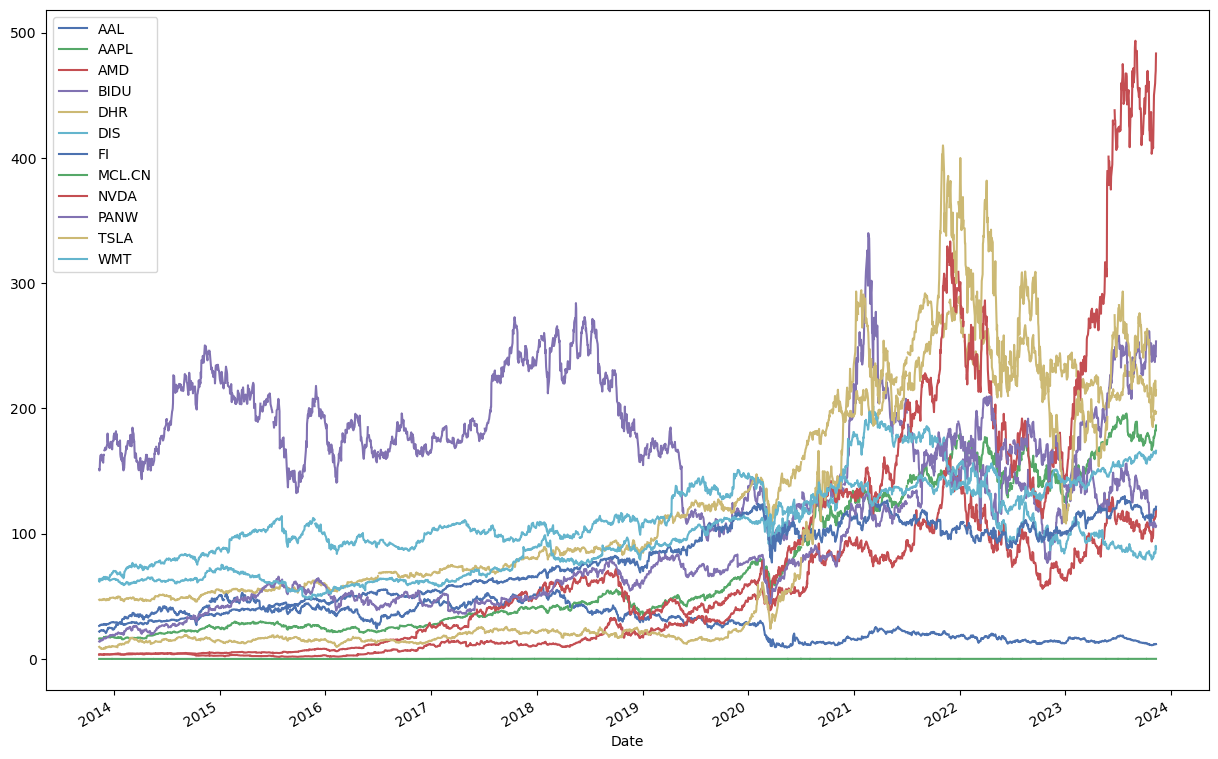

In [7]:
#Quick chart of prices over time for basket of stocks
prices[prices.index >= "2013-01-01"].plot(figsize=(15,10));

In [8]:
#created a covariance matrix through pyportfolioOpt to compare all stocks to eachother
sample_cov = risk_models.sample_cov(prices, frequency=252)
sample_cov

,AAL,AAPL,AMD,BIDU,DHR,DIS,FI,MCL.CN,NVDA,PANW,TSLA,WMT
AAL,0.25,0.04,0.06,0.06,0.03,0.06,0.04,-0.01,0.07,0.05,0.07,0.01
AAPL,0.04,0.08,0.07,0.04,0.03,0.03,0.03,0.00,0.07,0.04,0.07,0.02
AMD,0.06,0.07,0.33,0.07,0.05,0.04,0.04,0.01,0.15,0.07,0.11,0.02
BIDU,0.06,0.04,0.07,0.20,0.03,0.04,0.03,0.01,0.07,0.05,0.08,0.01
DHR,0.03,0.03,0.05,0.03,0.05,0.02,0.03,0.00,0.05,0.03,0.04,0.01
DIS,0.06,0.03,0.04,0.04,0.02,0.07,0.04,0.01,0.05,0.04,0.04,0.01
FI,0.04,0.03,0.04,0.03,0.03,0.04,0.06,-0.00,0.05,0.03,0.04,0.02
MCL.CN,-0.01,0.00,0.01,0.01,0.00,0.01,-0.00,3.54,0.00,-0.02,0.01,0.00
NVDA,0.07,0.07,0.15,0.07,0.05,0.05,0.05,0.00,0.21,0.07,0.11,0.02
PANW,0.05,0.04,0.07,0.05,0.03,0.04,0.03,-0.02,0.07,0.15,0.08,0.01


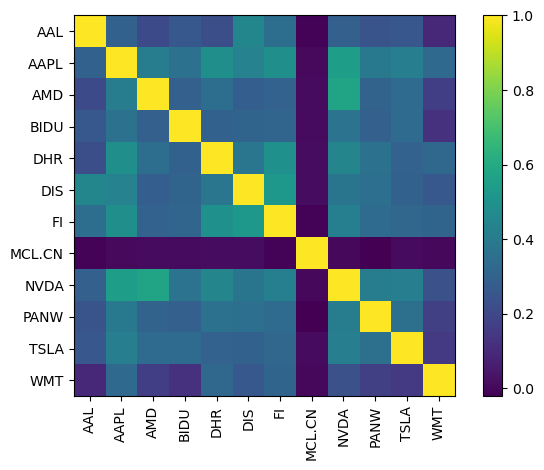

In [9]:
#plotted the correlations.  MCL.CN is the interesting product here with low correlation to essentially all other products here.
plotting.plot_covariance(sample_cov, plot_correlation=True);

In [10]:
#Used pyportfolioOpt to find our expected returns per stock using Capital Asset Pricing Model.
mu = expected_returns.capm_return(prices)
mu

AAL      0.34
AAPL     0.25
AMD      0.47
BIDU     0.33
DHR      0.18
DIS      0.22
FI       0.20
MCL.CN   1.58
NVDA     0.42
PANW     0.28
TSLA     0.45
WMT      0.11
Name: mkt, dtype: float64

In [11]:
# Use hvplot.bar to create bar plot with categorical data
bar_chart=pd.DataFrame(mu)
bar_chart.hvplot.bar(
    x="index", 
    y="mkt", 
    color="green",
    xlabel="Ticker", 
    ylabel="Daily Return", 
    title="Daily Return",
    rot=90
)

:Bars   [index]   (mkt)

Portfolio Allocation


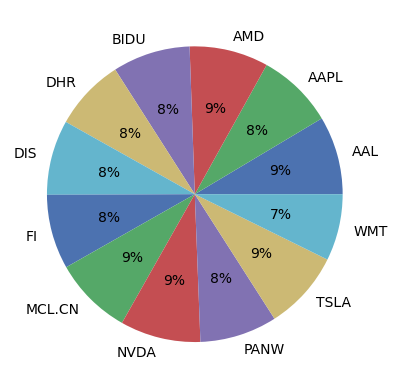

In [12]:

#PyportfolioOpt finding weights for our optimized portfolio on the efficient frontier
S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe() #for maximizing the Sharpe ratio #Optimization
cleaned_weights = ef.clean_weights() #to clean the raw weights
# Get the Keys and store them in a list
labels = list(cleaned_weights.keys())
# Get the Values and store them in a list
values = list(cleaned_weights.values())
fig, ax = plt.subplots()
ax.pie(values, labels=labels, autopct='%1.0f%%')
print('Portfolio Allocation')
plt.show(fig)

In [13]:
#Displaying cleaned weights dictionary output
cleaned_weights

OrderedDict([('AAL', 0.08565),
             ('AAPL', 0.08359),
             ('AMD', 0.08639),
             ('BIDU', 0.08486),
             ('DHR', 0.07821),
             ('DIS', 0.08194),
             ('FI', 0.08156),
             ('MCL.CN', 0.08585),
             ('NVDA', 0.08802),
             ('PANW', 0.08452),
             ('TSLA', 0.08651),
             ('WMT', 0.07289)])

In [14]:
#Taking the cleaned weights and inserting them into a df.  
#Named columns and set the index as the Stock column to easily work with additional downstream data.
clean_weights_df = pd.DataFrame(list(cleaned_weights.items()), columns=['Stock', 'Weight'])
clean_weights_df.set_index("Stock", inplace=True)
clean_weights_df

,Weight
Stock,
AAL,0.09
AAPL,0.08
AMD,0.09
BIDU,0.08
DHR,0.08
DIS,0.08
FI,0.08
MCL.CN,0.09
NVDA,0.09


In [15]:
#Finding the discrete allocation using pyportfolioOpt with prices on a given date, our weights, and portfolio size
latest_prices = prices.loc[portfolio_creation_date]  # prices as of the day you are allocating
da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=100000)
alloc, leftover = da.lp_portfolio(verbose=False)
print(f"Discrete allocation performed with ${leftover:.2f} leftover")
alloc

Discrete allocation performed with $132.69 leftover


{'AAL': 726,
 'AAPL': 45,
 'AMD': 73,
 'BIDU': 80,
 'DHR': 40,
 'DIS': 93,
 'FI': 67,
 'MCL.CN': 114473,
 'NVDA': 18,
 'PANW': 33,
 'TSLA': 40,
 'WMT': 44}

In [16]:
ef.portfolio_performance(verbose=True);

Expected annual return: 41.1%
Annual volatility: 27.3%
Sharpe Ratio: 1.43


In [17]:
idx = pd.date_range( start='2013-01-01',end='2023-11-09', freq='M')

stock_data_pctchange = prices.pct_change().cumsum()

stock_data_pctchange.dropna(how="all")

,AAL,AAPL,AMD,BIDU,DHR,DIS,FI,MCL.CN,NVDA,PANW,TSLA,WMT
Date,,,,,,,,,,,,
2013-11-12,0.01,0.00,0.03,-0.01,-0.01,-0.01,0.00,0.00,0.00,-0.01,-0.05,-0.00
2013-11-13,0.00,0.00,0.06,0.01,-0.01,0.01,0.02,0.00,0.03,-0.01,-0.04,-0.00
2013-11-14,0.02,0.02,0.05,0.05,0.00,0.02,0.02,0.00,0.03,0.01,-0.05,0.00
2013-11-15,0.03,0.01,0.05,0.07,0.00,0.02,0.03,0.00,0.03,0.09,-0.06,0.00
2013-11-18,0.05,-0.00,0.04,0.07,0.00,0.02,0.04,0.00,0.01,0.06,-0.17,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-06,0.61,2.80,5.15,0.64,1.68,0.67,1.83,16.76,5.89,3.59,4.69,1.16
2023-11-07,0.62,2.82,5.17,0.63,1.70,0.67,1.82,16.76,5.89,3.61,4.70,1.17
2023-11-08,0.64,2.82,5.17,0.63,1.69,0.67,1.83,16.76,5.90,3.60,4.70,1.16


In [18]:
stock_data_pctchange.hvplot.line(
    xlabel="Year", 
    ylabel="Daily Return",
    title="Value"
)

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

In [19]:
#Taking the allocation dictionary above and inserting it into  df.
alloc_df = pd.DataFrame(list(alloc.items()), columns=['Stock', 'Value'])
alloc_df.set_index("Stock", inplace=True)
alloc_df

,Value
Stock,
AAL,726
AAPL,45
AMD,73
BIDU,80
DHR,40
DIS,93
FI,67
MCL.CN,114473
NVDA,18


In [20]:
#Checking current values per given stock
current_values = prices.loc[portfolio_rebalance_date] * alloc_df["Value"]
current_values

AAL      8566.80
AAPL     8388.00
AMD      8657.07
BIDU     8475.20
DHR      7880.00
DIS      8209.11
FI       8141.17
MCL.CN   8585.48
NVDA     8700.30
PANW     8365.83
TSLA     8586.00
WMT      7312.36
dtype: float64

In [21]:
#Taking the sum
current_values_sum = current_values.sum(numeric_only=True)
current_values_sum

99867.31475575268

In [22]:
#Adding cash leftover
total_value = current_values_sum + leftover
total_value

99999.9998886266

In [23]:
#Getting the daily returns per stock
combined_returns_ef = prices.pct_change()
combined_returns_ef

,AAL,AAPL,AMD,BIDU,DHR,DIS,FI,MCL.CN,NVDA,PANW,TSLA,WMT
Date,,,,,,,,,,,,
2013-11-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-11-12,0.01,0.00,0.03,-0.01,-0.01,-0.01,0.00,0.00,0.00,-0.01,-0.05,-0.00
2013-11-13,-0.01,0.00,0.03,0.02,-0.00,0.02,0.01,0.00,0.03,0.00,0.01,0.00
2013-11-14,0.02,0.01,-0.01,0.04,0.01,0.02,0.00,0.00,0.00,0.02,-0.01,0.00
2013-11-15,0.01,-0.01,-0.01,0.02,0.00,-0.00,0.01,0.00,-0.00,0.08,-0.02,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-06,-0.03,0.01,-0.00,-0.01,-0.01,-0.01,0.00,0.00,0.02,-0.03,-0.00,0.00
2023-11-07,0.01,0.01,0.02,-0.00,0.01,0.01,-0.00,0.00,0.00,0.02,0.01,0.00
2023-11-08,0.02,0.01,0.00,-0.01,-0.01,-0.00,0.01,0.00,0.01,-0.00,-0.00,-0.01


In [24]:
#Finding the returns of the optimized portfolio
portfolio_returns_ef = combined_returns_ef.dot(clean_weights_df["Weight"])
portfolio_returns_ef

Date
2013-11-11     NaN
2013-11-12   -0.00
2013-11-13    0.01
2013-11-14    0.01
2013-11-15    0.01
              ... 
2023-11-06   -0.01
2023-11-07    0.01
2023-11-08    0.00
2023-11-09   -0.00
2023-11-10    0.02
Length: 2562, dtype: float64

In [25]:
#Finding the cumulative returns of the optimized portfolio
cumulative_returns_ef = (1 + portfolio_returns_ef).cumprod()
cumulative_returns_ef

Date
2013-11-11     NaN
2013-11-12    1.00
2013-11-13    1.01
2013-11-14    1.01
2013-11-15    1.02
              ... 
2023-11-06   32.76
2023-11-07   33.02
2023-11-08   33.09
2023-11-09   33.00
2023-11-10   33.53
Length: 2562, dtype: float64

In [26]:
#Simulating growth of our 100k initial investment
investment_ammount = 100000
cumulative_profit_ef = investment_ammount * cumulative_returns_ef
cumulative_profit_ef.hvplot(
    x='Date', 
    #y='housing_units',
    title="Cumulative Profit of Optimized Portfolio",
    rot=45,
    xlabel='Date', 
    ylabel='Profit'
).opts(yformatter='%.0f')

:Curve   [Date]   (0)

In [27]:
#Dictionary of equal weights
equal_weights = {'AAL': 0.08333,
             'BIDU': 0.08333,
             'DHR': 0.08333,
             'DIS': 0.08333,
             'FI': 0.08333,
             'AAPL': 0.08333,
             'MCL.CN': 0.08333,
             'NVDA': 0.08333,
             'PANW': 0.08333,
             'AMD': 0.08333,
             'TSLA': 0.08333,
             'WMT': 0.08333}

print(equal_weights)

{'AAL': 0.08333, 'BIDU': 0.08333, 'DHR': 0.08333, 'DIS': 0.08333, 'FI': 0.08333, 'AAPL': 0.08333, 'MCL.CN': 0.08333, 'NVDA': 0.08333, 'PANW': 0.08333, 'AMD': 0.08333, 'TSLA': 0.08333, 'WMT': 0.08333}


In [28]:
#Inserting equal weights into a df
equal_weights_df = pd.DataFrame(list(equal_weights.items()), columns=['Stock', 'Weight'])
equal_weights_df.set_index("Stock", inplace=True)
equal_weights_df

,Weight
Stock,
AAL,0.08
BIDU,0.08
DHR,0.08
DIS,0.08
FI,0.08
AAPL,0.08
MCL.CN,0.08
NVDA,0.08
PANW,0.08


In [29]:
#Using PyportfolioOpt again to find allocations for this equal weight portfolio
latest_prices = prices.loc[portfolio_creation_date]  # prices as of the day you are allocating
da_ew = DiscreteAllocation(equal_weights, latest_prices, total_portfolio_value=100000)
alloc_ew, leftover_ew = da_ew.lp_portfolio(verbose=False)
print(f"Discrete allocation performed with ${leftover_ew:.2f} leftover")
alloc_ew

Discrete allocation performed with $56.24 leftover


{'AAL': 706,
 'BIDU': 45,
 'DHR': 70,
 'DIS': 79,
 'FI': 42,
 'AAPL': 94,
 'MCL.CN': 69,
 'NVDA': 111136,
 'PANW': 17,
 'AMD': 33,
 'TSLA': 39,
 'WMT': 50}

In [30]:
#Inserting allocations into a df
alloc_ew_df = pd.DataFrame(list(alloc_ew.items()), columns=['Stock', 'Value'])
alloc_ew_df.set_index("Stock", inplace=True)
alloc_ew_df

,Value
Stock,
AAL,706
BIDU,45
DHR,70
DIS,79
FI,42
AAPL,94
MCL.CN,69
NVDA,111136
PANW,17


In [31]:
#Finding the current values per stock
current_values_ew = prices.loc[portfolio_rebalance_date] * alloc_ew_df["Value"]
current_values_ew

AAL          8330.80
AAPL        17521.60
AMD          3913.47
BIDU         4767.30
DHR         13790.00
DIS          6973.33
FI           5103.42
MCL.CN          5.18
NVDA     53717586.28
PANW         4309.67
TSLA         8371.35
WMT          8309.50
dtype: float64

In [32]:
#Finding the current value of the portfolio
current_values_ew_sum = current_values_ew.sum(numeric_only=True)
current_values_ew_sum

53798981.89248563

In [33]:
#adding the leftover cash back to get the total value
total_value_ew = current_values_ew_sum + leftover_ew
total_value_ew

53799038.13271482

In [34]:
#Getting returns for our equal weight portfolio
combined_returns_ew = prices.pct_change()
combined_returns_ew

,AAL,AAPL,AMD,BIDU,DHR,DIS,FI,MCL.CN,NVDA,PANW,TSLA,WMT
Date,,,,,,,,,,,,
2013-11-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-11-12,0.01,0.00,0.03,-0.01,-0.01,-0.01,0.00,0.00,0.00,-0.01,-0.05,-0.00
2013-11-13,-0.01,0.00,0.03,0.02,-0.00,0.02,0.01,0.00,0.03,0.00,0.01,0.00
2013-11-14,0.02,0.01,-0.01,0.04,0.01,0.02,0.00,0.00,0.00,0.02,-0.01,0.00
2013-11-15,0.01,-0.01,-0.01,0.02,0.00,-0.00,0.01,0.00,-0.00,0.08,-0.02,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-06,-0.03,0.01,-0.00,-0.01,-0.01,-0.01,0.00,0.00,0.02,-0.03,-0.00,0.00
2023-11-07,0.01,0.01,0.02,-0.00,0.01,0.01,-0.00,0.00,0.00,0.02,0.01,0.00
2023-11-08,0.02,0.01,0.00,-0.01,-0.01,-0.00,0.01,0.00,0.01,-0.00,-0.00,-0.01


In [35]:
#test_weights = [0.0833, 0.0833, 0.0833, 0.0833, 0.0833, 0.0833, 0.0833, 0.0833, 0.0833, 0.0833, 0.0833, 0.0833]
portfolio_returns_ew = combined_returns_ew.dot(equal_weights_df)

In [36]:
#Getting cumulative returns for our equal weight portfolio
cumulative_returns_ew = (1 + portfolio_returns_ew).cumprod()
cumulative_returns_ew

,Weight
Date,
2013-11-11,NaN
2013-11-12,1.00
2013-11-13,1.01
2013-11-14,1.01
2013-11-15,1.02
...,...
2023-11-06,30.61
2023-11-07,30.85
2023-11-08,30.91


In [37]:
#investment_ammount = 100000
cumulative_profit_ew = investment_ammount * cumulative_returns_ew
cumulative_profit_ew.hvplot(
    x='Date', 
    #y='housing_units',
    title="Cumulative Profit of Equal Weight Portfolio",
    rot=45,
    xlabel='Date', 
    ylabel='Profit'
).opts(yformatter='%.0f')

:Curve   [Date]   (Weight)

In [38]:
#Getting 10y data for SPY, our baseline
spy = ["SPY"] 
spy_data = yf.download(spy, period="10y")

[*********************100%%**********************]  1 of 1 completed


In [39]:
#Closing prices for SPY
spy_prices = pd.DataFrame(spy_data["Adj Close"].dropna(how="all"))
spy_prices.tail()

,Adj Close
Date,
2023-11-06,435.69
2023-11-07,436.93
2023-11-08,437.25
2023-11-09,433.84
2023-11-10,440.61


In [40]:
# Calculate Daily Returns
daily_returns_spy = spy_prices.pct_change()
daily_returns_spy.columns = ["SPY"]
daily_returns_spy.head()

,SPY
Date,
2013-11-11,NaN
2013-11-12,-0.00
2013-11-13,0.01
2013-11-14,0.00
2013-11-15,0.00


In [41]:
#SPY cumulative returns
cumulative_returns_spy = (1 + daily_returns_spy).cumprod()
cumulative_returns_spy.head()

,SPY
Date,
2013-11-11,NaN
2013-11-12,1.00
2013-11-13,1.01
2013-11-14,1.01
2013-11-15,1.02


In [42]:
#Getting std dev for spy
stddev_spy = daily_returns_spy.std()
stddev_spy

SPY   0.01
dtype: float64

In [43]:
#spy std dev annualized
stddev_annualized_spy = stddev_spy * np.sqrt(252)
stddev_annualized_spy

SPY   0.18
dtype: float64

In [44]:
#Calculating SPY Sharpe Ratio
sharpe_ratio_spy = (daily_returns_spy.mean() * 252) / (stddev_annualized_spy)
sharpe_ratio_spy

SPY   0.71
dtype: float64

In [45]:
#SPY expected returns
mu_spy = expected_returns.capm_return(spy_prices)
mu_spy

Adj Close   0.12
Name: mkt, dtype: float64

In [46]:
cumulative_profit_spy = investment_ammount * cumulative_returns_spy
cumulative_profit_spy.hvplot(
    x='Date', 
    #y='housing_units',
    title="Cumulative Profit of the SP500 using SPY",
    rot=45,
    xlabel='Date', 
    ylabel='Profit'
).opts(yformatter='%.0f')

:Curve   [Date]   (SPY)

In [47]:
#Combining the 3 portfolios to 1 df to better display results
combined_df = pd.concat([cumulative_profit_ef,cumulative_profit_ew,cumulative_profit_spy], axis='columns', join='inner')
combined_df.columns = ["Optimized", "Equal Weight","SPY"]
combined_df

,Optimized,Equal Weight,SPY
Date,,,
2013-11-11,NaN,NaN,NaN
2013-11-12,99660.79,99658.35,99796.95
2013-11-13,100586.52,100565.89,100597.77
2013-11-14,101462.41,101441.03,101099.69
2013-11-15,102300.54,102276.37,101539.58
...,...,...,...
2023-11-06,3276053.19,3060756.13,294797.61
2023-11-07,3302017.02,3084927.89,295636.61
2023-11-08,3309359.12,3091122.89,295853.14


In [48]:
combined_df.hvplot(
    x='Date', 
    #y='housing_units',
    title="Cumulative Profits Compared",
    rot=45,
    xlabel='Date', 
    ylabel='Profit'
).opts(yformatter='%.0f')

:NdOverlay   [Variable]
   :Curve   [Date]   (value)